In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os
import pickle
from PIL import Image
import random
import warnings
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, MobileNetV2, DenseNet169

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
train_dir = './../data/cleaned/ferplusbalanced/train/'
test_dir = './../data/cleaned/ferplusbalanced/test/'

input_size = (48, 48)
labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(48, 48),
                                                    class_mode='categorical',
                                                    subset='training',
                                                    classes=labels,
                                                    batch_size=32)

val_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                target_size=(48, 48),
                                                class_mode='categorical',
                                                subset='validation',
                                                classes=labels,
                                                batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(48, 48),
                                                  class_mode='categorical',
                                                  classes=labels,
                                                  batch_size=32)

Found 18603 images belonging to 7 classes.
Found 4648 images belonging to 7 classes.
Found 5772 images belonging to 7 classes.


In [12]:
# Building Model

base_model = tf.keras.applications.MobileNet(input_shape=(48,48,3),include_top=False,weights="imagenet")

for layer in base_model.layers[:]:
    layer.trainable=True

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(len(labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Compiling + fitting

callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1),
             ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')]

history = model.fit(train_generator, validation_data=val_generator, epochs=100, batch_size=64, verbose=2, callbacks=callbacks)

Epoch 1/100
582/582 - 23s - loss: 1.8463 - accuracy: 0.2325 - val_loss: 1.5391 - val_accuracy: 0.3677 - lr: 0.0010 - 23s/epoch - 40ms/step
Epoch 2/100
582/582 - 21s - loss: 1.5811 - accuracy: 0.3454 - val_loss: 1.4161 - val_accuracy: 0.4596 - lr: 0.0010 - 21s/epoch - 35ms/step
Epoch 3/100
582/582 - 20s - loss: 1.4610 - accuracy: 0.4360 - val_loss: 1.1260 - val_accuracy: 0.5716 - lr: 0.0010 - 20s/epoch - 35ms/step
Epoch 4/100
582/582 - 20s - loss: 1.3570 - accuracy: 0.4888 - val_loss: 1.0649 - val_accuracy: 0.5960 - lr: 0.0010 - 20s/epoch - 35ms/step
Epoch 5/100
582/582 - 20s - loss: 1.3085 - accuracy: 0.5149 - val_loss: 1.1118 - val_accuracy: 0.5914 - lr: 0.0010 - 20s/epoch - 34ms/step
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
582/582 - 20s - loss: 1.2774 - accuracy: 0.5337 - val_loss: 1.1377 - val_accuracy: 0.5826 - lr: 0.0010 - 20s/epoch - 34ms/step
Epoch 7/100
582/582 - 20s - loss: 1.2378 - accuracy: 0.5547 - val_loss: 0.9417 - val_acc

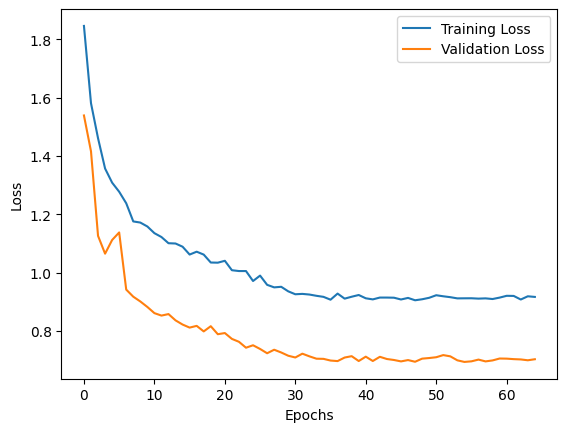

In [14]:
# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model_reduced_classes.h5')
model.save(file_path)

In [16]:
# Making predictions for the test set

y_pred_proba = model.predict(test_generator)

y_pred = [np.argmax(x) for x in y_pred_proba]

y_pred

181/181 [==============================] - 50s 276ms/step


[4,
 1,
 6,
 0,
 0,
 0,
 2,
 2,
 1,
 5,
 0,
 0,
 6,
 0,
 4,
 5,
 0,
 4,
 5,
 6,
 4,
 2,
 5,
 5,
 2,
 3,
 4,
 1,
 2,
 1,
 5,
 3,
 2,
 5,
 0,
 2,
 5,
 6,
 4,
 2,
 2,
 0,
 1,
 5,
 5,
 6,
 3,
 4,
 4,
 5,
 6,
 0,
 5,
 2,
 0,
 5,
 6,
 2,
 4,
 2,
 4,
 2,
 4,
 4,
 2,
 5,
 4,
 6,
 4,
 1,
 3,
 6,
 3,
 6,
 3,
 2,
 3,
 6,
 2,
 5,
 4,
 6,
 3,
 3,
 0,
 4,
 4,
 5,
 5,
 1,
 5,
 4,
 4,
 3,
 5,
 0,
 6,
 6,
 4,
 1,
 4,
 1,
 1,
 0,
 6,
 6,
 0,
 3,
 1,
 5,
 1,
 4,
 4,
 1,
 2,
 0,
 4,
 2,
 2,
 4,
 1,
 4,
 2,
 5,
 4,
 6,
 1,
 4,
 1,
 4,
 4,
 6,
 2,
 4,
 4,
 5,
 5,
 6,
 5,
 3,
 4,
 5,
 4,
 5,
 6,
 6,
 0,
 5,
 4,
 6,
 2,
 0,
 3,
 3,
 5,
 6,
 0,
 6,
 3,
 1,
 6,
 6,
 4,
 3,
 4,
 0,
 6,
 0,
 5,
 1,
 2,
 6,
 2,
 1,
 1,
 1,
 4,
 2,
 5,
 6,
 0,
 3,
 3,
 0,
 2,
 5,
 6,
 2,
 2,
 4,
 5,
 5,
 5,
 3,
 0,
 0,
 1,
 4,
 2,
 1,
 4,
 5,
 4,
 5,
 1,
 0,
 4,
 6,
 2,
 0,
 2,
 5,
 4,
 1,
 5,
 6,
 6,
 2,
 1,
 5,
 0,
 5,
 0,
 6,
 6,
 1,
 0,
 4,
 6,
 0,
 1,
 5,
 4,
 3,
 1,
 2,
 6,
 3,
 0,
 5,
 6,
 0,
 2,
 4,
 4,
 0,
 0,
 5,
 2,
 4,


In [18]:
print(test_generator)

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1216
           1       0.56      0.55      0.56       625
           2       0.41      0.43      0.42       511
           3       0.42      0.52      0.47       654
           4       0.88      0.86      0.87      1960
           5       0.74      0.67      0.70      1997
           6       0.55      0.60      0.57      1383
           7       0.71      0.67      0.69      1797

    accuracy                           0.66     10143
   macro avg       0.61      0.61      0.61     10143
weighted avg       0.67      0.66      0.66     10143

Cohen-Kappa score: 0.6002801934378389


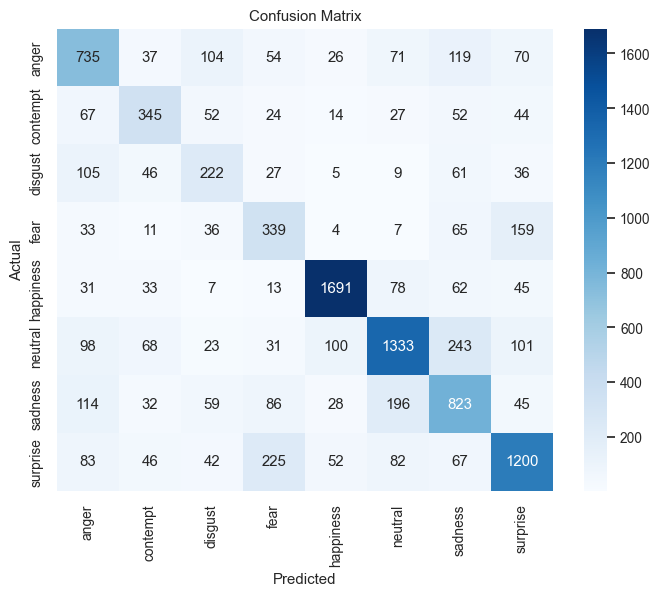

In [28]:
# Performance metrics on test set

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [21]:
# Creating a more complex model

model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))

model2.add(layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu'))

model2.add(layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu'))

model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(512, kernel_size=3, strides=2, padding='same', activation='relu'))
model2.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(layers.BatchNormalization())

# Flattening + dense layers with dropout
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.BatchNormalization())

# Output layer
model2.add(layers.Dense(8, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)       

In [25]:
from keras.utils import to_categorical

# Assuming y_train_np contains integer class indices
y_train_one_hot = to_categorical(y_train_np, num_classes=8)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(X_train_np, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, verbose=2, callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard])

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.34942, saving model to best_model.h5
710/710 - 16s - loss: 1.8330 - accuracy: 0.3166 - val_loss: 1.6692 - val_accuracy: 0.3494 - lr: 0.0010 - 16s/epoch - 23ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6777 - accuracy: 0.3322 - val_loss: 1.6966 - val_accuracy: 0.3330 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6553 - accuracy: 0.3399 - val_loss: 1.6253 - val_accuracy: 0.3389 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.34942
710/710 - 12s - loss: 1.6368 - accuracy: 0.3419 - val_loss: 1.6130 - val_accuracy: 0.3364 - lr: 0.0010 - 12s/epoch - 17ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.34942 to 0.35893, saving model to best_model.h5
710/710 - 12s - loss: 1.6142 - accuracy: 0.3567 - val_loss: 1.6508 - val_accuracy: 0.3589 - lr: 0.0010 - 12s/e

In [24]:
y_train_np

array([5, 5, 4, ..., 4, 4, 0], dtype=int64)

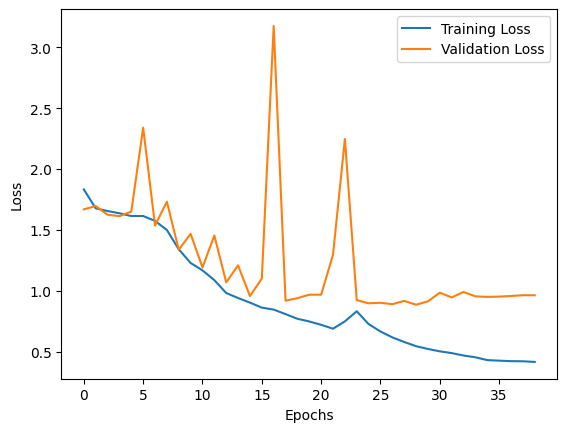

In [27]:
# Plotting train and val losses

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model2.h5')
model.save(file_path)

In [29]:
# Making predictions for the test set

y_pred_proba2 = model2.predict(X_test_np)

y_pred2 = [np.argmax(x) for x in y_pred_proba2]

y_pred2

222/222 [==============================] - 2s 6ms/step


[4,
 0,
 0,
 5,
 5,
 5,
 5,
 0,
 5,
 4,
 5,
 5,
 6,
 5,
 6,
 5,
 6,
 4,
 7,
 0,
 6,
 4,
 4,
 4,
 7,
 0,
 5,
 6,
 0,
 0,
 7,
 7,
 5,
 6,
 4,
 4,
 4,
 0,
 0,
 5,
 4,
 4,
 5,
 0,
 5,
 5,
 7,
 5,
 5,
 4,
 5,
 4,
 6,
 5,
 5,
 5,
 4,
 7,
 4,
 0,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 6,
 4,
 0,
 5,
 4,
 6,
 4,
 5,
 7,
 0,
 6,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 0,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 4,
 5,
 6,
 7,
 5,
 6,
 6,
 5,
 0,
 5,
 5,
 5,
 4,
 7,
 4,
 5,
 4,
 5,
 6,
 7,
 4,
 4,
 5,
 4,
 7,
 5,
 5,
 5,
 6,
 5,
 5,
 6,
 4,
 6,
 5,
 7,
 5,
 0,
 6,
 4,
 6,
 5,
 4,
 5,
 5,
 0,
 6,
 6,
 4,
 4,
 7,
 4,
 5,
 5,
 5,
 5,
 4,
 7,
 6,
 5,
 5,
 6,
 5,
 4,
 4,
 5,
 7,
 7,
 4,
 4,
 6,
 7,
 5,
 5,
 5,
 0,
 5,
 5,
 4,
 5,
 6,
 5,
 5,
 5,
 0,
 7,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 7,
 6,
 0,
 4,
 5,
 6,
 5,
 5,
 6,
 7,
 0,
 6,
 0,
 5,
 4,
 0,
 4,
 4,
 5,
 0,
 5,
 6,
 7,
 5,
 0,
 4,
 6,
 5,
 5,
 6,
 6,
 4,
 5,
 5,
 0,
 6,
 6,
 0,
 6,
 7,
 5,
 7,
 7,
 7,
 4,
 4,
 5,
 4,
 6,
 5,
 5,
 4,
 5,


Classification report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       753
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.80      0.90      0.85      1652
           5       0.82      0.74      0.78      2884
           6       0.38      0.36      0.37       912
           7       0.78      0.77      0.77       896

    accuracy                           0.71      7097
   macro avg       0.43      0.41      0.42      7097
weighted avg       0.73      0.71      0.72      7097

Cohen-Kappa score: 0.6130948111490646


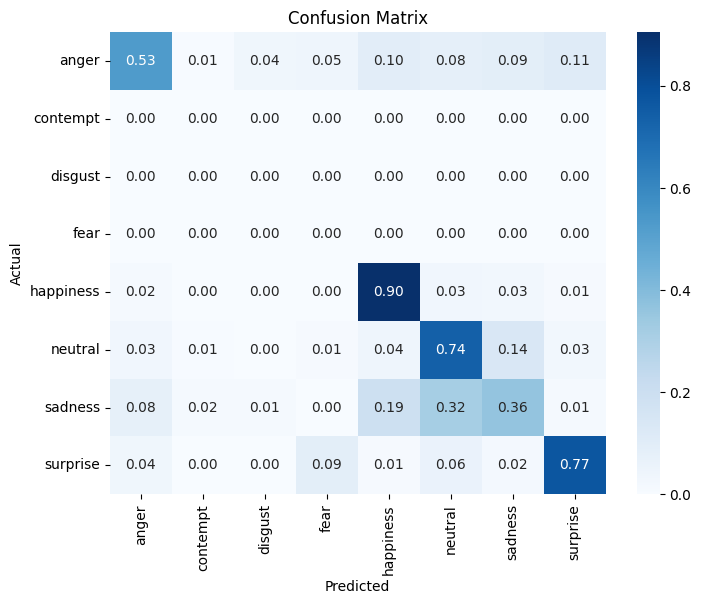

In [30]:
# Performance metrics on test set

cr2 = classification_report(y_pred2, y_test)
print(f'Classification report:\n{cr2}')

chs2 = cohen_kappa_score(y_pred2, y_test)
print(f'Cohen-Kappa score: {chs2}')

cm2 = confusion_matrix(y_pred2, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Transfer learning with EfficientNet

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freezing pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Adding dense layers on top of EfficientNetB0
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))

model3.summary()

In [ ]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
# Plotting train and val losses

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model3.h5')
model.save(file_path)

In [ ]:
# Making predictions for the test set

y_pred_proba3 = model3.predict(X_test_np)

y_pred3 = [np.argmax(x) for x in y_pred_proba3]

y_pred3

In [ ]:
# Performance metrics on test set

cr3 = classification_report(y_pred3, y_test)
print(f'Classification report:\n{cr3}')

chs3 = cohen_kappa_score(y_pred3, y_test)
print(f'Cohen-Kappa score: {chs3}')

cm3 = confusion_matrix(y_pred3, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()